## Neutralization curves for luciferase pseudovirus expressing A12_2718 rabies G

Authored by Arjun Aditham. These are neutralization curves shown in Figure 6D of the manuscript. This notebook analyzes the data for pseudovirus displaying glycoprotein from the A12_2718 strain (here denoted as AGN) for antibodies. This notebook has some file dependencies in 'RawData'

In [1]:
import pandas as pd
from matplotlib import pyplot as pl
#import seaborn as sb
import numpy as np
import matplotlib.cm as cm
import scipy.stats
from matplotlib.colors import ListedColormap

In [2]:
#read in excel documents with data


Plate1_data = pd.read_excel('RawData/240825_CircStrain-AGN_NeutData.xlsx','PV');
Plate1_data['virus']='PV';

Plate2_data = pd.read_excel('RawData/240825_CircStrain-AGN_NeutData.xlsx','AGN');
Plate2_data['virus']='AGN';




#antibody map

antibody_map = pd.read_excel('RawData/240825_AntibodyNeutMap.xlsx');
antibody_map=antibody_map.rename(columns={"col_coordinate": "Column"})



In [3]:
antibody_map

,Column,Antibody,Antibody_High_Conc
0,1,NaN,0
1,2,NaN,0
2,3,17C7,500
3,4,17C7,500
4,5,RVC58,1000
5,6,RVC58,1000
6,7,CR57,1000
7,8,CR57,1000
8,9,RVC20,100
9,10,RVC20,100


In [4]:
#process plate reader data from raw format

def format_plate_data(plate_df,antibodymap_df):
    #take plate_df and convert well into Row and Column
    plate_copy = plate_df.copy();

    plate_copy['Row']=plate_copy['Well'].apply(lambda x: x[0]);
    plate_copy['Column']=plate_copy['Well'].apply(lambda x: int(x[1:]));


    #okay let's get the background values of the plate. Here, I'll take column 12 which only has media
    media_only = plate_copy[plate_copy['Column']==12]
    bg = media_only['RLU'].tolist();
    bg_median = np.median(bg);

    #okay let's now noise correct all RLU values
    plate_copy['RLU_bgsub'] = plate_copy['RLU'].apply(lambda x: x-bg_median);

    #now we need to merge in the antibody map and get concentrations.
    plate_copy = pd.merge(plate_copy,antibody_map,how='left',on=['Column'])

    #okay let's convert the Row values to an ordinal value for dilution factor.
    plate_copy['Dilution_factor']=plate_copy['Row'].apply(lambda x: ord(x)-65);
    plate_copy['antibody_conc']=plate_copy['Antibody_High_Conc']/5**plate_copy['Dilution_factor']

    #okay now we need to calculate the RLU fraction.
    #no antibody columns = 2,11
    columns = [2,11];
    
    no_antibody = plate_copy[plate_copy['Column'].isin(columns)];
    No_antibody_RLU_list = list(no_antibody['RLU_bgsub']);
    No_antibody_RLU = np.median(No_antibody_RLU_list);

    plate_copy['no_antibody_RLU'] = No_antibody_RLU;
    plate_copy['frac_infectivity']= plate_copy['RLU_bgsub'].apply(lambda x: x/No_antibody_RLU);

    return plate_copy;



In [5]:
Plate1_data_processed = format_plate_data(Plate1_data,antibody_map);
Plate2_data_processed = format_plate_data(Plate2_data,antibody_map);




In [6]:
Plate1_data_processed

,Well,Group,Type,Sample,RLU,Time [s],virus,Row,Column,RLU_bgsub,Antibody,Antibody_High_Conc,Dilution_factor,antibody_conc,no_antibody_RLU,frac_infectivity
0,A01,Group 1,Unknown,Un0097,59190.0000,666.71,PV,A,1,59186.3175,NaN,0,0,0.0000,82116.3175,0.720762
1,A02,Group 1,Unknown,Un0098,49700.0000,667.96,PV,A,2,49696.3175,NaN,0,0,0.0000,82116.3175,0.605194
2,A03,Group 1,Unknown,Un0099,6.9970,669.21,PV,A,3,3.3145,17C7,500,0,500.0000,82116.3175,0.000040
3,A04,Group 1,Unknown,Un0100,6.8060,670.46,PV,A,4,3.1235,17C7,500,0,500.0000,82116.3175,0.000038
4,A05,Group 1,Unknown,Un0101,0.2005,671.71,PV,A,5,-3.4820,RVC58,1000,0,1000.0000,82116.3175,-0.000042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,H05,Group 1,Unknown,Un0185,87520.0000,780.58,PV,H,5,87516.3175,RVC58,1000,7,0.0128,82116.3175,1.065760
92,H04,Group 1,Unknown,Un0184,130200.0000,781.83,PV,H,4,130196.3175,17C7,500,7,0.0064,82116.3175,1.585511
93,H03,Group 1,Unknown,Un0183,162000.0000,783.08,PV,H,3,161996.3175,17C7,500,7,0.0064,82116.3175,1.972766
94,H02,Group 1,Unknown,Un0182,97870.0000,784.33,PV,H,2,97866.3175,NaN,0,7,0.0000,82116.3175,1.191801


In [7]:
#okay maybe we should format some things to make neut-curve compatible.

neutCurve_subset_1=Plate1_data_processed[['virus','Antibody','frac_infectivity','antibody_conc','Column']];
neutCurve_subset_1 = neutCurve_subset_1.rename(columns={'Antibody':'serum','frac_infectivity':'fraction infectivity',
                                                        'Column':'replicate','antibody_conc':'concentration'})
                                                        

neutCurve_subset_2=Plate2_data_processed[['virus','Antibody','frac_infectivity','antibody_conc','Column']];
neutCurve_subset_2 = neutCurve_subset_2.rename(columns={'Antibody':'serum','frac_infectivity':'fraction infectivity',
                                                        'Column':'replicate','antibody_conc':'concentration'})


neutCurve_subset_1 = neutCurve_subset_1.dropna();
neutCurve_subset_2 = neutCurve_subset_2.dropna();

dfs = [neutCurve_subset_1,neutCurve_subset_2];

final = pd.concat(dfs);

siteIII_antibodies = ['17C7','RVC58'];

final=final[final['serum'].isin(siteIII_antibodies)]

In [8]:
neutCurve_subset_1

,virus,serum,fraction infectivity,concentration,replicate
2,PV,17C7,0.000040,500.0000,3
3,PV,17C7,0.000038,500.0000,4
4,PV,RVC58,-0.000042,1000.0000,5
5,PV,RVC58,-0.000026,1000.0000,6
6,PV,CR57,-0.000140,1000.0000,7
...,...,...,...,...,...
89,PV,CR57,0.974305,0.0128,7
90,PV,RVC58,1.083540,0.0128,6
91,PV,RVC58,1.065760,0.0128,5
92,PV,17C7,1.585511,0.0064,4


In [9]:
import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

pd.set_option('display.float_format', '{:.3g}'.format)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

import os
import yaml

import neutcurve.parse_excel

In [10]:
fits = neutcurve.CurveFits(neutCurve_subset_1,fixtop=False)

In [11]:
fits.fitParams(ics=(50,90,99))

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,PV,average,2,0.442,interpolated,0.442,4.78,interpolated,4.78,...,interpolated,97.9,0.111,0.111,interpolated,0.778,1.97,0,0.996,0.0434
1,RVC58,PV,average,2,0.194,interpolated,0.194,1.06,interpolated,1.06,...,interpolated,7.28,0.165,0.165,interpolated,1.24,1.11,0,0.997,0.0224
2,CR57,PV,average,2,0.251,interpolated,0.251,0.743,interpolated,0.743,...,interpolated,2.66,0.198,0.198,interpolated,1.86,1.28,0,0.997,0.0281
3,RVC20,PV,average,2,0.126,interpolated,0.126,0.902,interpolated,0.902,...,interpolated,10.1,0.0568,0.0568,interpolated,0.978,1.59,0,0.994,0.0492


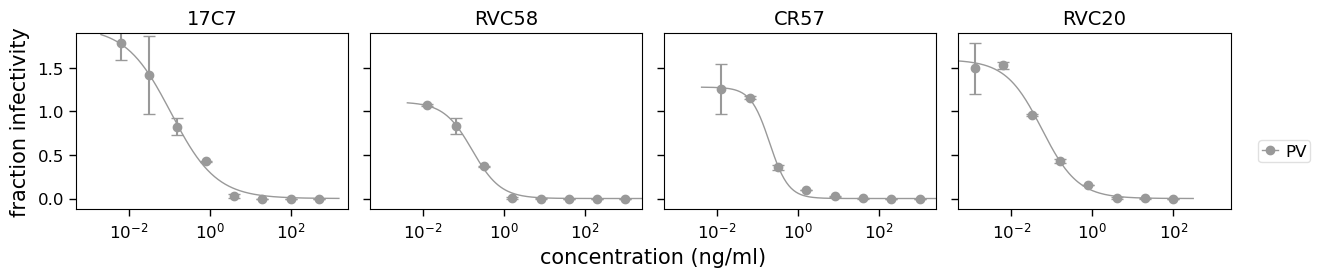

In [12]:
fig, axes = fits.plotSera(xlabel='concentration (ng/ml)')

In [13]:
fits_2 = neutcurve.CurveFits(neutCurve_subset_2,fixtop=False)
fits_2.fitParams(ics=(50,90,99))

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,AGN,average,2,500,lower,>500,500,lower,>500,...,lower,>500,1.17e+15,500,lower,0.0428,1.32,0,0.549,0.0267
1,RVC58,AGN,average,2,0.42,interpolated,0.42,3.24,interpolated,3.24,...,interpolated,31.5,0.376,0.376,interpolated,1.05,1.06,0,0.999,0.0141
2,CR57,AGN,average,2,0.246,interpolated,0.246,1.02,interpolated,1.02,...,interpolated,4.72,0.254,0.254,interpolated,1.56,0.976,0,0.999,0.00988
3,RVC20,AGN,average,2,0.0555,interpolated,0.0555,0.271,interpolated,0.271,...,interpolated,1.56,0.0528,0.0528,interpolated,1.37,1.03,0,0.997,0.0229


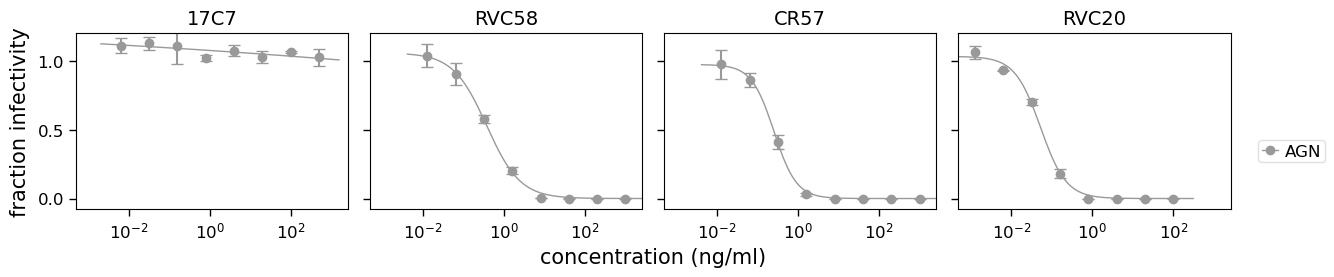

In [14]:
fig, axes = fits_2.plotSera(xlabel='concentration (ng/ml)')

In [15]:
fits = neutcurve.CurveFits(final,fixtop=False)
fits.fitParams(ics=(50,90,99))

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,PV,average,2,0.442,interpolated,0.442,4.78,interpolated,4.78,...,interpolated,97.9,0.111,0.111,interpolated,0.778,1.97,0,0.996,0.0434
1,17C7,AGN,average,2,500,lower,>500,500,lower,>500,...,lower,>500,1.17e+15,500,lower,0.0428,1.32,0,0.549,0.0267
2,RVC58,PV,average,2,0.194,interpolated,0.194,1.06,interpolated,1.06,...,interpolated,7.28,0.165,0.165,interpolated,1.24,1.11,0,0.997,0.0224
3,RVC58,AGN,average,2,0.42,interpolated,0.42,3.24,interpolated,3.24,...,interpolated,31.5,0.376,0.376,interpolated,1.05,1.06,0,0.999,0.0141


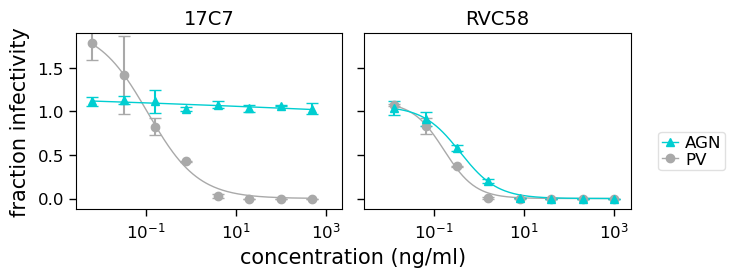

In [16]:
fig, axes = fits.plotSera(xlabel='concentration (ng/ml)',
                          virus_to_color_marker={'AGN':('darkturquoise','^'),
                                                 'PV':('darkgrey','o')},
                          draw_in_bounds=True)

#suppress output for notebook -- we really wanted to show 17C7 and RVC58 data specifically which is plotted here.
#fig.savefig('241204_AGN_Neut-Curves.svg')